Git commit to reproduce: b4ab2633be4a5048efa579dc3c47c5ff019e446e


In [4]:
# %env CUDA_VISIBLE_DEVICES=
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

import pandas as pd
import sys
sys.path.append('source/')

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [22]:
from sklearn.model_selection import ParameterGrid

def foo(script, params, gpus=[], bs=1, changer={}):
    scheduler = []
    n_gpu = len(gpus)
    
    base = 'python ' + script
    for k, _ in params.items():
        base += ' --{} {{{}}}'.format(k, changer.get(k, k))
    if len(gpus) > 0:
        base += ' --gpu {gpu}'

    grid = ParameterGrid(params)
    for i, p in enumerate(grid):
        p['gpu'] = gpus[i % n_gpu]
        run = ''
        run = base.format(**p)
        run += '\n' if (i + 1) % (n_gpu * bs) == 0 else ' &\n'
        scheduler.append(run)

    return scheduler

def get_logs(df, script):
    logs = pd.DataFrame()
    for _id, row in df.iterrows():
        tmp = pd.read_csv(row['root']/'{}-logs.csv'.format(script))
        for k, v in row.items():
            try:
                tmp[k] = v
            except:
                pass
        logs = logs.append(tmp, ignore_index=True)
    return logs

In [19]:
params = {
    'num-examples': [10, 20, 30, 40, 100, 500, 4000],
    'seed': np.arange(4),
    'data-split-seed': [0],
    'vae': ['./vae/z-dim=2,hidden-dim=32/0/'],
    'prior': ['dwp', 'sn'],
    'lr': [0.01, 0.001, 0.0001],
#     'z-dim': [2],
#     'kernel-dim': [16],
    'hid-dim': [20, 40, 100, 500],
    'kl-weight': [1.],
    'name': ['dwp-sn-init-full-grid'],
    'data': ['shapes'],
    'model': ['shapes'],
    'epochs': [200],
    'init': ['vae', 'xavier'],
}

tmp = foo('train-bnn.py', params, np.arange(1, 8), bs=6, changer={'data-split-seed': 'seed'})

with open('./sh-scripts/dwp-sn-init-full-grid.sh', 'w') as f:
    f.write(''.join(tmp))

In [15]:
params = {
    'num-examples': [10, 20, 30, 40, 100, 500, 4000],
    'seed': np.arange(4),
    'data-split-seed': [0],
    'vae': ['./vae/z-dim=2,hidden-dim=32/0/'],
    'lr': [0.01, 0.001, 0.0001],
    'hid-dim': [20, 40, 100, 500],
    'net-cfg': ['vanilla'],
    'name': ['vanilla-init-full-grid'],
    'data': ['shapes'],
    'model': ['shapes'],
    'epochs': [100],
    'init': ['vae', 'xavier'],
}

gpus = [0, 1, 2, 4, 6] # <--- DEFINE GPUs
tmp = foo('train-net.py', params, gpus, bs=6, changer={'data-split-seed': 'seed'})
print('%d exps' % len(tmp))
with open('./sh-scripts/{}.sh'.format(params['name'][0]), 'w') as f:
    f.write(''.join(tmp))

672 exps


In [28]:
import exman
index = exman.Index('./exman-train-bnn.py/')
df = index.info()

logs = get_logs(df[df['name'] == 'dwp-sn-init-full-grid'], 'train-bnn.py')
logs = logs[logs['t'] == 200]

logs['prior+init'] = logs['prior'] + ' (' + logs['init'] + ' init)'

In [29]:
import exman
index = exman.Index('./exman/')
df = index.info()


vanilla_logs = get_logs(df[df['name'] == 'vanilla-init-full-grid'], 'train-net.py')
vanilla_logs = vanilla_logs[vanilla_logs['t'] == 100]

vanilla_logs['prior+init'] = 'vanilla (' + vanilla_logs['init'] + ' init)'

In [35]:
vanilla_logs['ens[10]_test_acc'] = vanilla_logs['test_acc']

In [46]:
vanilla_logs['num_examples'] = vanilla_logs['num_examples'].astype(int)

/Vol0/user/hse/toretto.gtr/miniconda3/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Vol0/user/hse/toretto.gtr/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


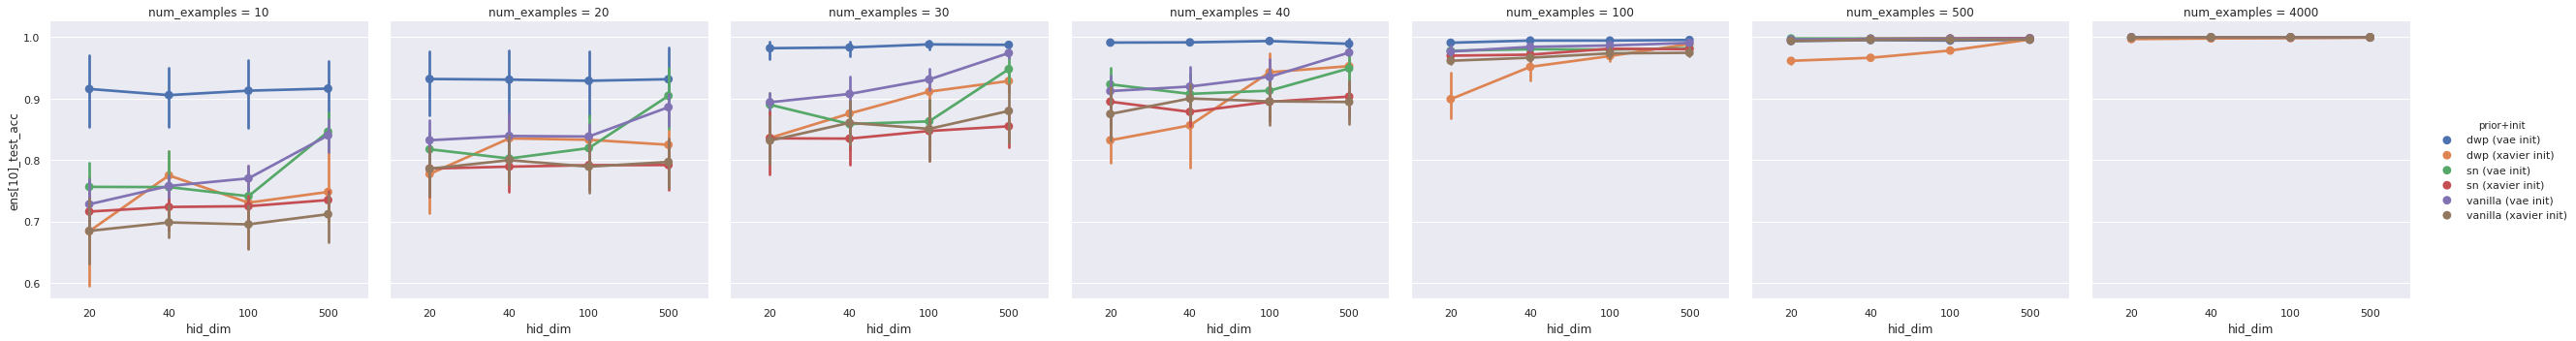

In [50]:
tmp = logs.append(vanilla_logs)
tmp.to_csv('SHAPES_Results_DWP+SN.csv')

# max over different lr
tmp = tmp.groupby(['hid_dim', 'num_examples', 'seed', 'prior+init']).agg({'ens[10]_test_acc': 'max'}).reset_index()
sns.catplot(x='hid_dim', y='ens[10]_test_acc',
            data=tmp,
            col='num_examples', hue='prior+init', kind='point')
plt.savefig('./plots/shapes-main-res', dpi=200)



/Vol0/user/hse/toretto.gtr/miniconda3/lib/python3.6/site-packages/pandas/core/frame.py:6211: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)
/Vol0/user/hse/toretto.gtr/miniconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


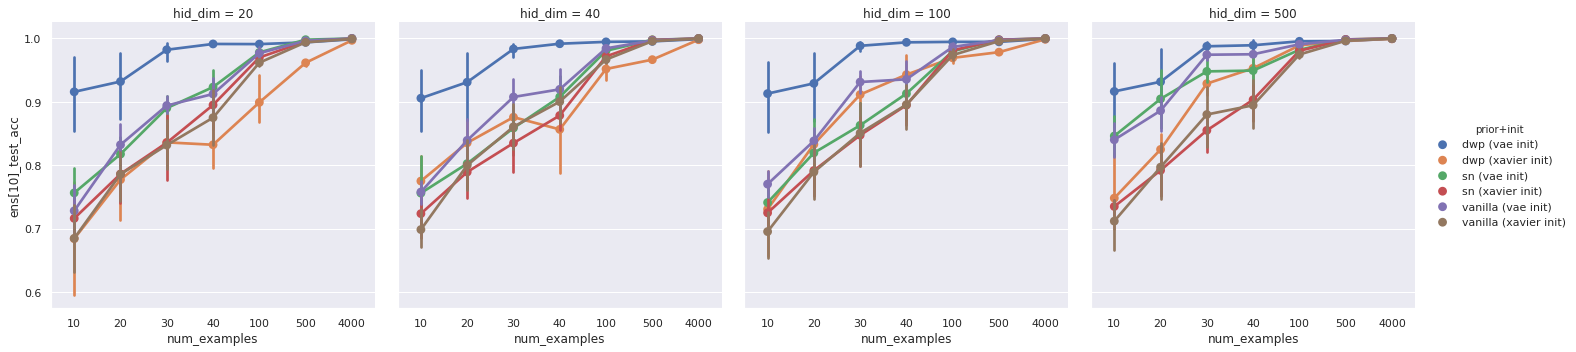

In [51]:
tmp = logs.append(vanilla_logs)
# max over different lr
tmp = tmp.groupby(['hid_dim', 'num_examples', 'seed', 'prior+init']).agg({'ens[10]_test_acc': 'max'}).reset_index()
sns.catplot(col='hid_dim', y='ens[10]_test_acc',
            data=tmp,
            x='num_examples', hue='prior+init', kind='point')
plt.savefig('./plots/shapes-main-res-1', dpi=200)

------

In [103]:
def plot_grid(imgs, ncol, nrow, w=2):
    h = imgs.shape[-1]
    tmp = imgs[np.newaxis].reshape((nrow, ncol, h, h))
    tmp = tmp.transpose((0, 2, 1, 3))
    tmp = tmp.reshape((nrow * h, ncol * h))

    plt.figure(figsize=(ncol * w + 2, nrow * w))
    plt.imshow(tmp, cmap='jet', aspect='auto')
    plt.xticks(np.arange(-0.5, ncol * h, h), np.arange(ncol))
    plt.yticks(np.arange(-0.5, nrow * h, h), np.arange(nrow) * ncol)
    plt.colorbar()

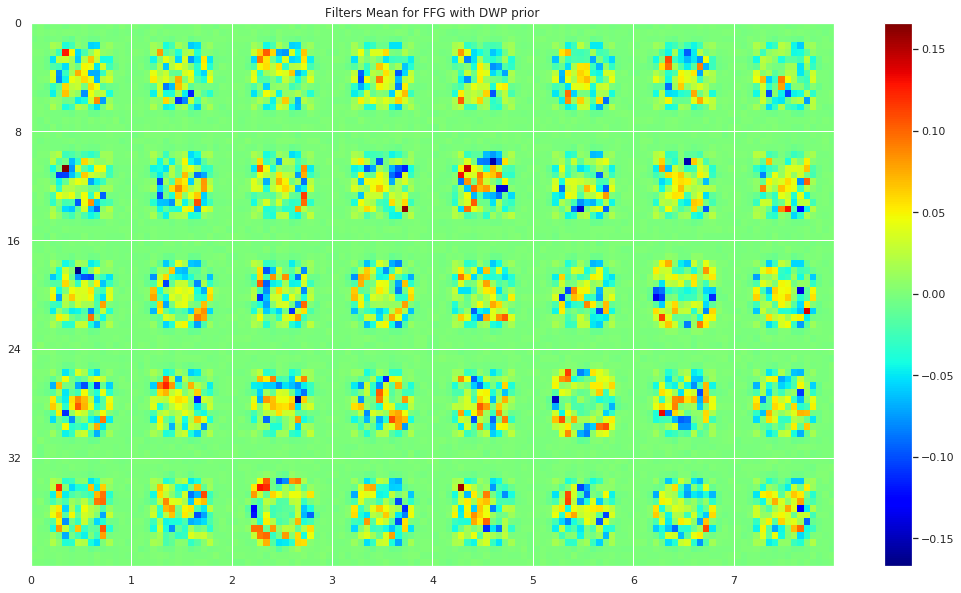

In [115]:
import yaml

base = df.query('hid_dim == 40 and num_examples == 10 and name == "dwp-it2-grid" and kl_weight == 1 and lr == 0.01')['root'].values[0]

with open(base/'params.yaml') as f:
    args = yaml.load(f)

from models.vae import Decoder16x16, Encoder16x16, VAE
from models.shapes import ShapeModel

d = torch.device('cuda')
net = ShapeModel(args['net_cfg'], device=d, hid_dim=args['hid_dim'])
net.load_state_dict(torch.load('exman-train-bnn.py/' + args['root'] + '/model.torch'))

m, v = map(utils.tonp, net.net[0].q_params())

m = m.reshape((-1, 16, 16))
v = v.reshape((-1, 16, 16))

plot_grid(m, 8, 5)
plt.title(r'Filters Mean for FFG with DWP prior');

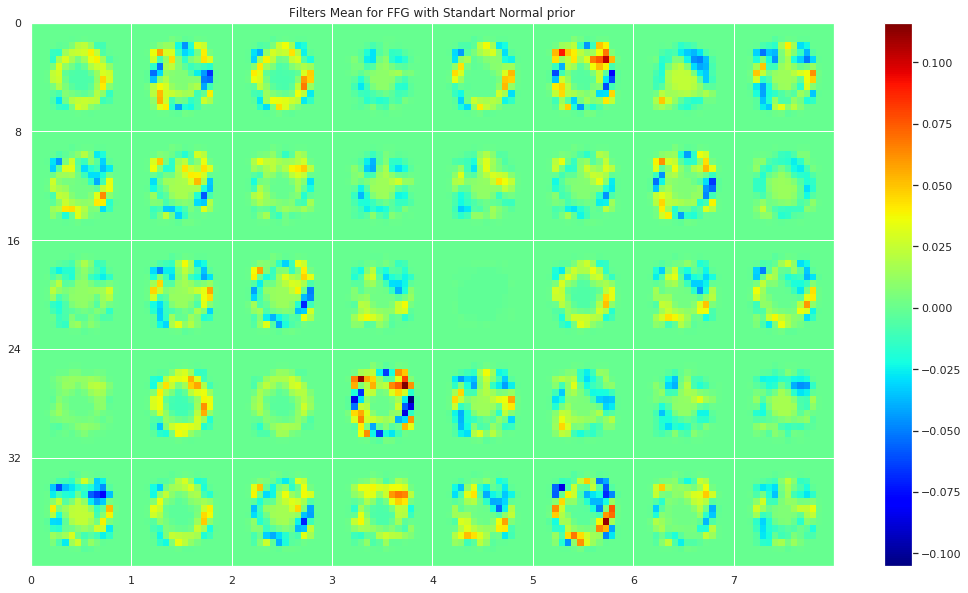

In [159]:
import yaml

base = df.query('hid_dim == 40 and num_examples == 10 and name == "sn-grid" and kl_weight == 1 and lr == 0.01')['root'].values[0]
args = base/'params.yaml'
with open(args) as f:
    args = yaml.load(f)

from models.vae import Decoder16x16, Encoder16x16, VAE
from models.shapes import ShapeModel

d = torch.device('cuda')
net = ShapeModel(args['net_cfg'], device=d, hid_dim=args['hid_dim'])
net.load_state_dict(torch.load('exman-train-bnn.py/' + args['root'] + '/model.torch'))

m, v = map(utils.tonp, net.net[0].q_params())

m = m.reshape((-1, 16, 16))
v = v.reshape((-1, 16, 16))

plot_grid(m, 8, 5)
plt.title(r'Filters Mean for FFG with Standart Normal prior');

In [262]:
logs.query('num_examples == 20 and lr == 0.01 and hid_dim == 40 and prior == "dwp"')['root'].values[0]

PosixPath('exman-train-bnn.py/runs/004877-2018-08-14-21-59-58')

In [266]:
ls -l exman-train-bnn.py/runs/004877-2018-08-14-21-59-58

total 353
-rw-r--r-- 1 toretto.gtr U_HSE  83818 Aug 14 22:00 model.torch
-rw-r--r-- 1 toretto.gtr U_HSE 167115 Aug 14 22:00 opt.torch
-rw-r--r-- 1 toretto.gtr U_HSE    555 Aug 14 21:59 params.yaml
-rw-r--r-- 1 toretto.gtr U_HSE  37945 Aug 14 22:00 train-bnn.py-logs.csv
-rw-r--r-- 1 toretto.gtr U_HSE  30684 Aug 14 22:00 train-bnn.py-logs.out
-rw-r--r-- 1 toretto.gtr U_HSE  17403 Aug 14 22:00 train-bnn.py-param-logs.csv


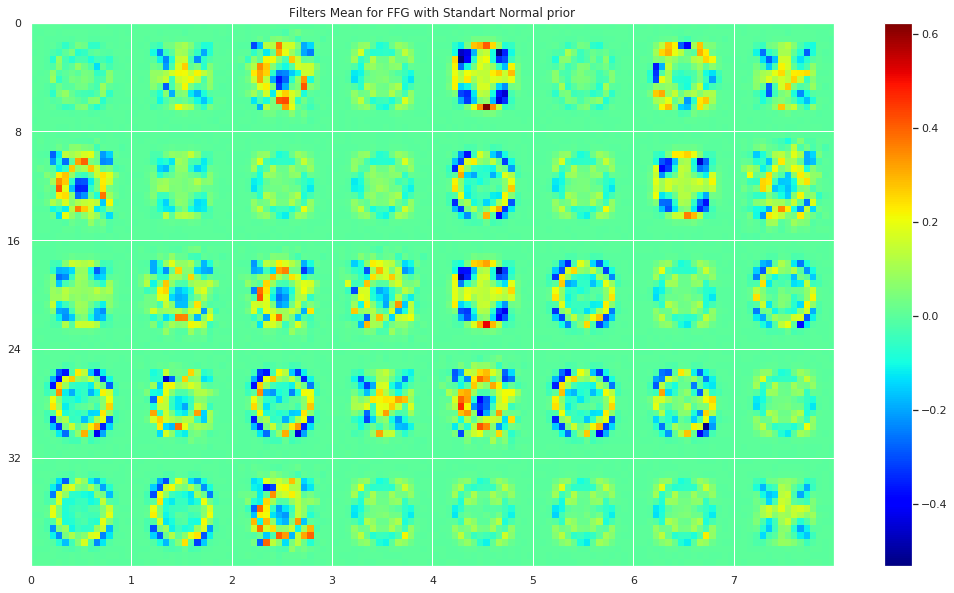

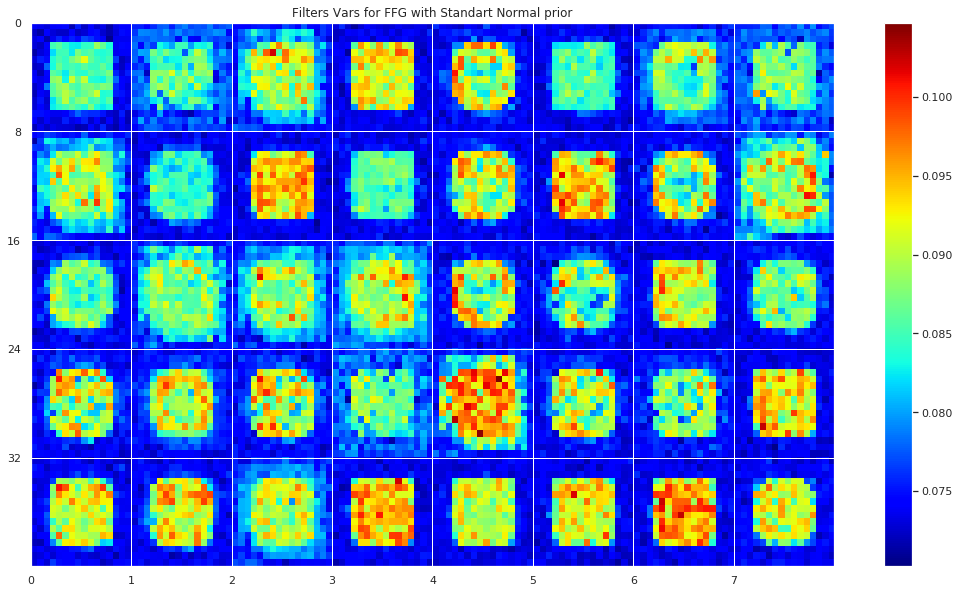

In [267]:
base = logs.query('num_examples == 20 and lr == 0.01 and hid_dim == 40 and prior == "dwp"')['root'].values[0]
args = base/'params.yaml'
with open(args) as f:
    args = yaml.load(f)

from models.vae import Decoder16x16, Encoder16x16, VAE
from models.shapes import ShapeModel

d = torch.device('cuda')
net = ShapeModel(args['net_cfg'], device=d, hid_dim=args['hid_dim'])
net.load_state_dict(torch.load('exman-train-bnn.py/' + args['root'] + '/model.torch'))

m, v = map(utils.tonp, net.net[0].q_params())

m = m.reshape((-1, 16, 16))
v = v.reshape((-1, 16, 16))

plot_grid(m, 8, 5)
plt.title(r'Filters Mean for FFG with Standart Normal prior');

plot_grid(np.sqrt(v), 8, 5)
plt.title(r'Filters Vars for FFG with Standart Normal prior');